## 1. Imports

In [20]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_recall_curve,
    average_precision_score,
    PrecisionRecallDisplay
    )
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

## 2. Funções

In [ ]:
def train(model, train_loader, optimizer, criterion, device, epochs=10):
    """
    Treina a rede neural com os dados de treinamento.
    Args:
        model (torch.nn.Module): A rede neural a ser treinada.
        train_loader (DataLoader): DataLoader com os dados de treinamento.
        optimizer (torch.optim.Optimizer): Otimizador para atualizar os pesos da rede.
        criterion (torch.nn.Module): Função de perda a ser utilizada.
        device (torch.device): Dispositivo no qual o modelo e os dados estão localizados.
        epochs (int): Número de épocas para treinar a rede.
    """
    epoch_array = []
    loss_array = []

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_array.append(epoch)
        loss_array.append(running_loss / len(train_loader))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")
    
    return epoch_array, loss_array


def evaluate(model, test_loader, device, class_names):
    """
    Avalia a rede neural com os dados de teste.
    Args:
        model (torch.nn.Module): A rede neural a ser avaliada.
        test_loader (DataLoader): DataLoader com os dados de teste.
        device (torch.device): Dispositivo no qual o modelo e os dados estão localizados.
        class_names (list): Lista com os nomes das classes.
    """
    model.eval()
    predictions = []
    class_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            class_labels.extend(labels.numpy())

    return predictions, class_labels

def get_probs_and_labels(model, test_loader, device, num_classes):
    """
    Obtém as probabilidades e os rótulos binarizados para cada classe.
    Args:
        model (torch.nn.Module): A rede neural a ser avaliada.
        test_loader (DataLoader): DataLoader com os dados de teste.
        device (torch.device): Dispositivo no qual o modelo e os dados estão localizados.
        num_classes (int): Número de classes no conjunto de dados.
    Returns:
        tuple: Rótulos binarizados e probabilidades para cada classe.
    """
    
    model.eval()
    probas = []
    binnarized_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            probas.append(probs.cpu())
            binnarized_labels.extend(labels.cpu().numpy())

    probas = torch.cat(probas, dim=0).numpy()
    binnarized_labels = label_binarize(binnarized_labels, classes=list(range(num_classes)))
    return binnarized_labels, probas

def plot_multiclass_pr_curve_with_iso_f1(y_true, y_probs, class_names=None):
    """
    Plota a curva de precisão-recall para múltiplas classes com linhas iso-F1.
    Args:
        y_true (array-like): Rótulos verdadeiros.
        y_probs (array-like): Probabilidades previstas para cada classe.
        class_names (list, optional): Lista com os nomes das classes. Se None, usa índices numéricos.
    """
    n_classes = y_probs.shape[1]
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    precision = dict()
    recall = dict()
    average_precision = dict()

    # Computar precisão e recall para cada classe
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        average_precision[i] = average_precision_score(y_true_bin[:, i], y_probs[:, i])

    # Micro-average
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        y_true_bin.ravel(), y_probs.ravel()
    )
    average_precision["micro"] = average_precision_score(y_true_bin, y_probs, average="micro")

    # Configurações do gráfico
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal", "crimson", "limegreen"])
    _, ax = plt.subplots(figsize=(6, 6))

    # Curvas iso-F1
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score + 1e-6)
        valid = y >= 0
        (l,) = ax.plot(x[valid], y[valid], color="gray", alpha=0.2, linestyle='--')
        ax.annotate(f"f1={f_score:0.1f}", xy=(0.9, f_score * 0.9 / (2 * 0.9 - f_score + 1e-6) + 0.02), fontsize=9)
    lines.append(l)
    labels.append("iso-F1 curves")

    # Curva micro-average
    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average PR", color="gold")

    # Curvas para cada classe
    for i, color in zip(range(n_classes), colors):
        name = class_names[i] if class_names else f"Class {i}"
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"PR para {name}", color=color, despine=True)

    # Plotagem final
    handles, plot_labels = ax.get_legend_handles_labels()
    handles.extend(lines)
    plot_labels.extend(labels)
    ax.legend(handles=handles, labels=plot_labels, loc="best")
    ax.set_title("Curvas PR para múltiplas classes com linhas iso-F1")
    ax.grid(True)
    plt.tight_layout()
    plt.savefig("../docs/curvas_pr.png")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, normalize=False, figsize=(6, 5), cmap='Blues'):
    """
    Plota a matriz de confusão.
    Args:
        y_true (array-like): Rótulos verdadeiros.
        y_pred (array-like): Rótulos previstos.
        class_names (list): Lista com os nomes das classes.
        normalize (bool): Se True, normaliza a matriz de confusão.
        figsize (tuple): Tamanho da figura.
        cmap (str): Mapa de cores para o gráfico.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)  # avoid NaNs from division by zero

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", 
                cmap=cmap, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Tumor Predito")
    plt.ylabel("Tumor Observado")
    plt.title("Matriz de Confusão" + (" (Normalizada)" if normalize else ""))
    
    # Salva a matriz de confusão
    plt.savefig("../docs/matriz_confusao.png")
    plt.tight_layout()

    plt.show()

## 3. Implementação da rede neural

In [3]:
class DeepBrain(nn.Module):
    """
    Rede Neural Convolucional para detecção de tumores cerebrais.
    Esta rede é composta por várias camadas convolucionais seguidas de camadas totalmente conectadas.
    """
    def __init__(self, num_classes):
        super(DeepBrain, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: (3, 224, 224)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: (32, 112, 112)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: (64, 56, 56)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: (128, 28, 28)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


## 4. Carregamento e tratamento das imagens

In [4]:
# Parâmetros
BATCH_SIZE = 32
IMAGE_SIZE = 224  # Redefinindo tamanho da imagem para o padrão de redes convulacionais (CNNs)
DATA_DIR = '/Users/rafaelmacedo/Documents/Code/eixo5_grupo5_20251/projeto/data'  # Path to your dataset folder
TRAIN_FOLDER = "Training"
TEST_FOLDER = "Testing"

# Transformações e enriquecimento de dados
train_transforms = transforms.Compose([
    # Converte imagens preto e branco para os canais RGB (vermelho, verde e azul). 
    # Isto é necessário pois as redes convulacionais esperam esses canais como input.
    transforms.Grayscale(num_output_channels=3),

    # Fixa as dimensões da imagem.
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    
    # Espelha a imagem para esquerda ou direita aleatoriamente
    transforms.RandomHorizontalFlip(),

    # Rotaciona a imagem em +- 10 graus aleatoriamente
    transforms.RandomRotation(10),

    # Converte para a estrutura de dados do PyTorch (tensor)
    transforms.ToTensor(),

    # Esta transformada consiste em escalonar os píxeis para média centrada no 0 e variância unitária.
    # Utiliza-se a média para cada canal de cor (vermelho, verde e azul).
    # Os valores de média e desvio-padrão são usados com base no projeto ImageNet.
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, TRAIN_FOLDER), transform=train_transforms)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, TEST_FOLDER), transform=test_transforms)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Nome das classes
class_names = train_dataset.classes
print(f"Classes: {class_names}")


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
# Define o dispositivo (GPU ou CPU)
# Se houver GPU disponível, utilize-a. Caso contrário, utilize a CPU.
# O objeto 'model' é a rede neural convolucional definida acima.
# O objeto 'criterion' é a função de perda utilizada para treinar a rede.
# O objeto 'optimizer' é o otimizador utilizado para atualizar os pesos da rede.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepBrain(num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Treina o modelo
# O modelo é treinado com os dados de treinamento, utilizando o otimizador e a função de perda definidos acima.
epochs, losses = train(model, train_loader, optimizer, criterion, device, epochs=10)

Epoch 1/10, Loss: 3.7101
Epoch 2/10, Loss: 0.6858
Epoch 3/10, Loss: 0.5978
Epoch 4/10, Loss: 0.5790
Epoch 5/10, Loss: 0.5737
Epoch 6/10, Loss: 0.5467
Epoch 7/10, Loss: 0.5264
Epoch 8/10, Loss: 0.5583
Epoch 9/10, Loss: 0.5230
Epoch 10/10, Loss: 0.5091


In [14]:
# Salva o modelo
SAVE_PATH = "../artefatos/cnn_model_weights.pth"
torch.save(model.state_dict(), SAVE_PATH)

In [8]:
# Avalia o modelo e retorna as previsões e os rótulos reais
preds, labels = evaluate(model, test_loader, device, class_names)

In [15]:
print(classification_report(labels, preds, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.92      0.63      0.74       300
  meningioma       0.64      0.68      0.66       306
     notumor       0.85      0.99      0.91       405
   pituitary       0.93      0.96      0.94       300

    accuracy                           0.83      1311
   macro avg       0.83      0.81      0.82      1311
weighted avg       0.83      0.83      0.82      1311



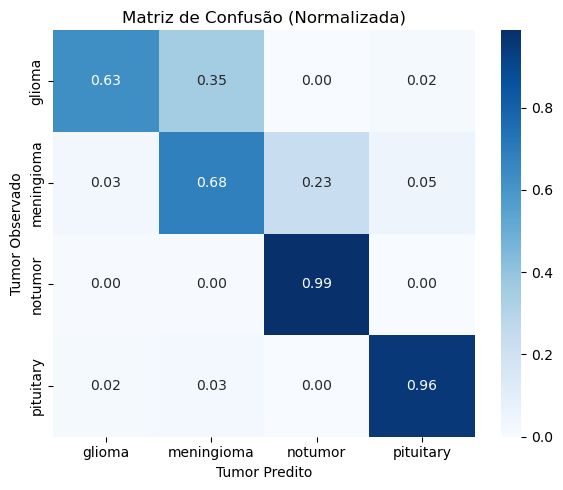

In [37]:
plot_confusion_matrix(labels, preds, class_names, normalize=True)

In [16]:
y_true_bin, y_proba = get_probs_and_labels(model, test_loader, device, num_classes=len(class_names))

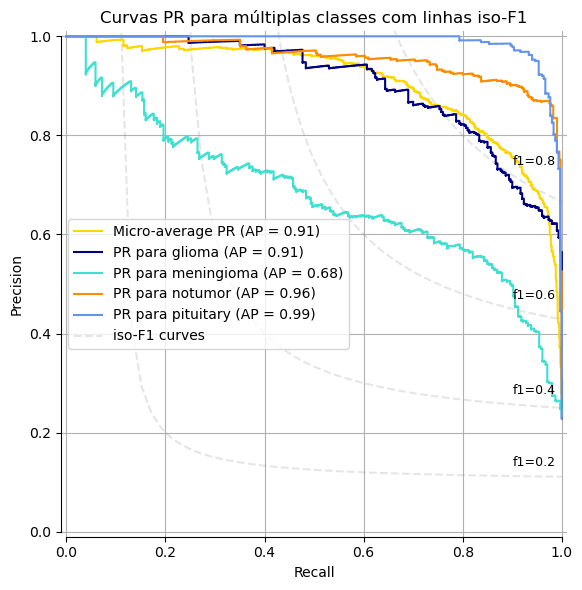

In [41]:
plot_multiclass_pr_curve_with_iso_f1(y_true_bin, y_proba, class_names)